<a href="https://colab.research.google.com/github/bmfmancini/Cacti-DB-Monitor-Template/blob/main/holt_winters_rrd_prediction_user_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
%%capture
!apt install rrdtool librrd-dev
!pip install prophet
!pip install matplotlib
!pip install pandas
!pip install rrdtool
!pip install statsmodels


In [11]:
import rrdtool
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import datetime
import os
import math
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import timezone


### Holt Winters Tripple Exponential Smoothing RRD Prediction Sample

#### Holt-Winters uses three smoothing parameters (α, β, γ) between 0 and 1:
- α (alpha): Level smoothing parameter
- β (beta): Trend smoothing parameter  
- γ (gamma): Seasonal smoothing parameter


In [9]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  print(uploaded[fn])


Saving local_linux_machine_load_1min_2.rrd to local_linux_machine_load_1min_2 (1).rrd
User uploaded file "local_linux_machine_load_1min_2 (1).rrd" with length 1967912 bytes


In [43]:
##Prompt user for DS_Name
input_ds_name = input("Enter the DS_Name: ")

Enter the DS_Name: load_5min


In [44]:
# ---- CONFIG ----
##get the file name from upload

# RRD_PATH =
RRD_PATH = list(uploaded.keys())[0] # Use the file path (string) from the keys of the uploaded dictionary

DS_NAME  = input_ds_name
CF       = "AVERAGE"
START    = "-30d"
END      = "now"
FORECAST_HOURS = 168        # 1 week forecast (7 * 24 = 168 hours)
ASSUME_STEP_SECONDS = 300
SEASONAL_PERIODS = int((24*3600) / ASSUME_STEP_SECONDS)  # daily seasonality

# ---- 1) FETCH FROM RRD ----
# rrdtool.fetch returns: (start, end, step), ds_names, data_rows
(time_info, ds_names, data) = rrdtool.fetch(
    RRD_PATH, CF, "--start", START, "--end", END
)

# Find index of DS_NAME
try:
    ds_index = ds_names.index(DS_NAME)
except ValueError:
    raise SystemExit(f"DS '{DS_NAME}' not found in {RRD_PATH}. Available: {ds_names}")

start_ts, end_ts, step = time_info

# Build timestamps and values
timestamps = pd.to_datetime(np.arange(start_ts, end_ts, step), unit="s", utc=True)
values = [row[ds_index] if row is not None else np.nan for row in data[:len(timestamps)]]

# Create a series
s = pd.Series(values, index=timestamps, name=DS_NAME)

# ---- 2) CLEAN/RESAMPLE ----
# If your RRD step is stable, resampling may be optional; we still ensure regularity.
s = s.asfreq(f"{step}s")

# Fill small gaps (NaNs) for model fit; keep a copy for plotting raw points if you prefer
s_filled = s.interpolate(limit_direction="both").fillna(method="bfill").fillna(method="ffill")

# ---- 3) FIT HOLT-WINTERS ----
# Choose additive or multiplicative depending on your data pattern
model = ExponentialSmoothing(
    s_filled,
    trend="add",
    seasonal="add",
    seasonal_periods=SEASONAL_PERIODS
)

fit = model.fit(optimized=True)

# ---- 4) FORECAST ----
forecast_steps = int((FORECAST_HOURS * 3600) / step)
forecast_index = pd.date_range(
    start=s_filled.index[-1] + pd.Timedelta(seconds=step),
    periods=forecast_steps,
    freq=f"{step}s",
    tz=timezone.utc
)
yhat = fit.forecast(forecast_steps)
yhat.index = forecast_index

# Simple prediction intervals (empirical residual std):
resid = s_filled - fit.fittedvalues.reindex_like(s_filled)
sigma = resid.dropna().std()
upper = yhat + 2 * sigma
lower = yhat - 2 * sigma

/tmp/ipython-input-1584035572.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s_filled = s.interpolate(limit_direction="both").fillna(method="bfill").fillna(method="ffill")
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


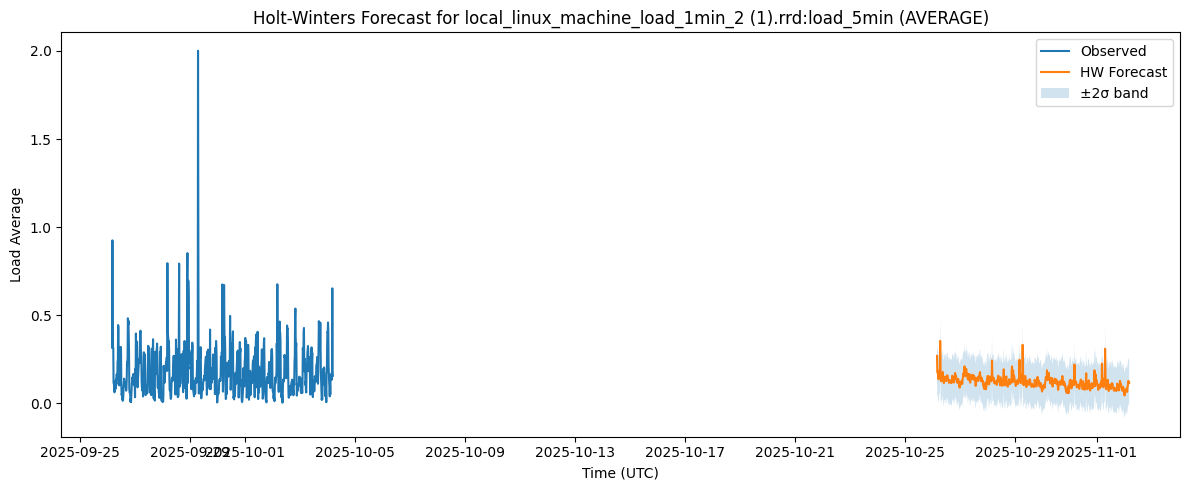

Anomalies in last 24h: 0


In [45]:
# ---- 5) PLOT ----
plt.figure(figsize=(12, 5))
plt.plot(s.index, s.values, label="Observed")
plt.plot(yhat.index, yhat.values, label="HW Forecast")
plt.fill_between(yhat.index, lower.values, upper.values, alpha=0.2, label="±2σ band")
plt.title(f"Holt-Winters Forecast for {os.path.basename(RRD_PATH)}:{DS_NAME} ({CF})")
plt.xlabel("Time (UTC)")
plt.ylabel("Load Average")
plt.legend()
plt.tight_layout()
plt.show()

# ---- OPTIONAL: BASIC ANOMALY FLAGGING ON HISTORY ----
# Compare the last day of observations to fitted band to flag outliers
window = int((24 * 3600) / step)
obs_tail = s_filled.tail(window)
fit_tail = fit.fittedvalues.reindex_like(s_filled).tail(window)
upper_tail = fit_tail + 2 * sigma
lower_tail = fit_tail - 2 * sigma
anomalies = obs_tail[(obs_tail > upper_tail) | (obs_tail < lower_tail)]
print(f"Anomalies in last 24h: {len(anomalies)}")


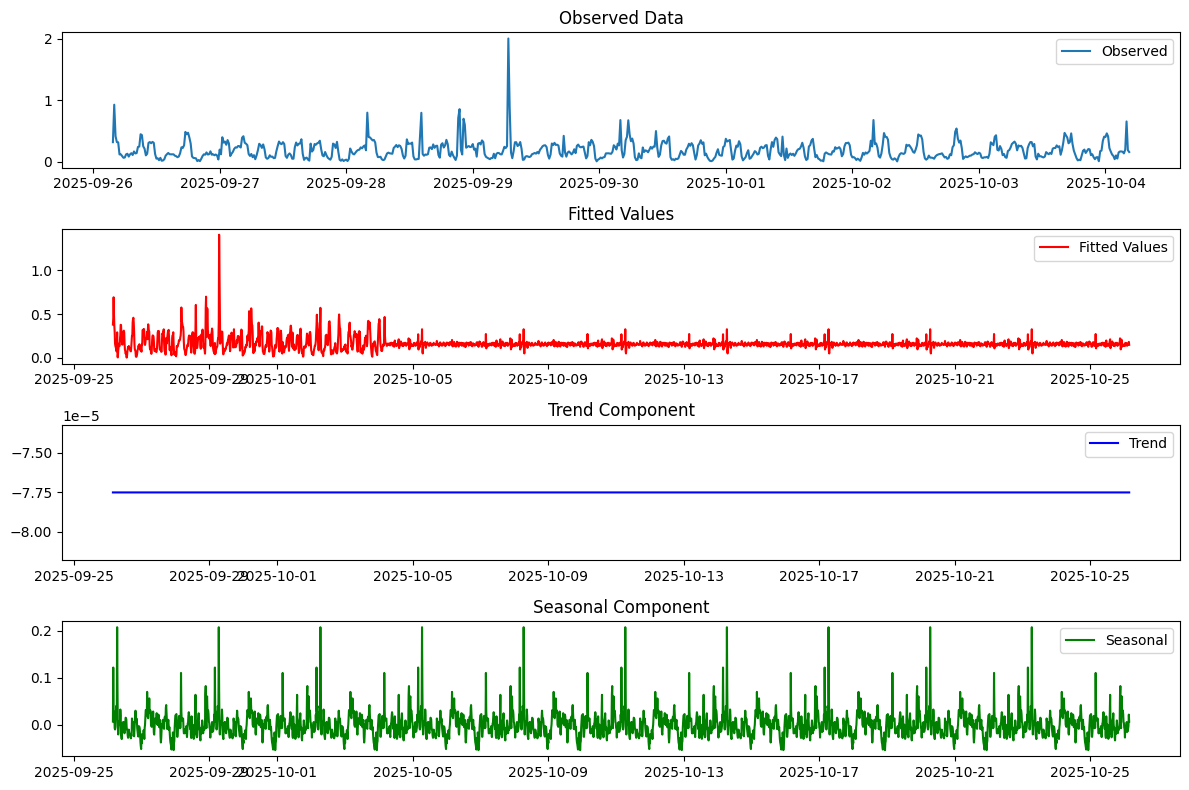

In [46]:
### Decompose and plot components
trend_component = fit.level + fit.trend if hasattr(fit, 'trend') else fit.level
seasonal_component = fit.season
fitted_values = fit.fittedvalues

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(s.index, s.values, label="Observed")
plt.title("Observed Data")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(fitted_values.index, fitted_values.values, label="Fitted Values", color='red')
plt.title("Fitted Values")
plt.legend()

plt.subplot(4, 1, 3)
if hasattr(fit, 'trend'):
    plt.plot(s.index[-len(fit.trend):], fit.trend, label="Trend", color='blue')
    plt.title("Trend Component")
else:
    plt.plot(s.index[-len(fit.level):], fit.level, label="Level", color='blue')
    plt.title("Level Component")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(s.index[-len(seasonal_component):], seasonal_component, label="Seasonal", color='green')
plt.title("Seasonal Component")
plt.legend()

plt.tight_layout()
plt.show()